In [73]:
!pwd

/content


In [74]:
!ls

data  deeplearning_model.py  model_weights  __pycache__  sample_data


# CNN卷积神经网络

In [75]:
import torch
import torchvision
import numpy as np
from torchvision import datasets, transforms
from deeplearning_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from deeplearning_model import evaluate_classification_model as evaluate_model
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.transforms as transforms
from  torchvision.transforms import Normalize

# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print(train_dataset[0])
train_dataset[0][0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7816F1F863D0>, 9)


# 加载数据并处理为tensor格式

In [76]:
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


# 获取图像和标签
# 注意：由于使用了transform，图像已经被转换为张量且标准化
# 我们需要从dataset中提取原始图像用于显示
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称标签
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")

训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000


In [77]:
# 从训练集中划分出验证集
train_size = 55000
val_size = 5000
# 设置随机种子以确保每次得到相同的随机划分结果
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset,
    [train_size, val_size],
    generator=generator #设置随机种子，确保每次得到相同的随机划分结果
)

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"训练批次数: {len(train_loader)}")

训练批次数: 860


In [78]:
# 计算训练集均值和方差，以便加载数据集时直接标准化
def calculate_mean_std(train_dataset):
    # 首先将所有图像数据堆叠为一个大张量
    all_images = torch.stack([img_tensor for img_tensor, _ in train_dataset])
    print(all_images.shape)
    # 计算通道维度上的均值和标准差
    # Fashion MNIST是灰度图像，只有一个通道
    # 对所有像素值计算均值和标准差
    mean = torch.mean(all_images)
    std = torch.std(all_images)

    print(f"训练数据集均值: {mean.item():.4f}")
    print(f"训练数据集标准差: {std.item():.4f}")

    # 检查数据集大小
    print(f"数据集中图像总数: {len(train_dataset)}")

calculate_mean_std(train_dataset)

torch.Size([60000, 1, 28, 28])
训练数据集均值: 0.2860
训练数据集标准差: 0.3530
数据集中图像总数: 60000


# 定义CNN模型类

## 深度可分离CNN

In [79]:

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        """
        深度可分离卷积模块

        参数:
            in_channels: 输入通道数
            out_channels: 输出通道数
            kernel_size: 卷积核大小
            stride: 步长
            padding: 填充
        """
        super(DepthwiseSeparableConv, self).__init__()

        # 深度卷积 - 对每个输入通道单独进行卷积操作
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels  # 将输入通道分组，每组一个通道
        )

        # 逐点卷积 - 使用1x1卷积进行通道混合
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )

    def forward(self, x):
        # 先进行深度卷积，再进行逐点卷积
        x = self.depthwise(x)  # 深度卷积
        x = self.pointwise(x)  # 逐点卷积
        return x





In [80]:
# 测试深度可分离卷积层
input_tensor = torch.randn(1, 3, 28, 28)  # 批次大小为1，3个输入通道，28x28图像
separable_conv = DepthwiseSeparableConv(in_channels=3, out_channels=16, kernel_size=3, padding=1)
output = separable_conv(input_tensor)
print(f"输入形状: {input_tensor.shape}")
print(f"输出形状: {output.shape}")
print(f"参数数量: {sum(p.numel() for p in separable_conv.parameters())}")

输入形状: torch.Size([1, 3, 28, 28])
输出形状: torch.Size([1, 16, 28, 28])
参数数量: 94


In [81]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        """
        深度可分离卷积模块

        参数:
            in_channels: 输入通道数
            out_channels: 输出通道数
            kernel_size: 卷积核大小
            stride: 步长
            padding: 填充
        """
        super().__init__()
        # normalize归一化
        self.transform = nn.Sequential(
            transforms.Normalize([0.2856], [0.3527])
        )

        # 深度卷积 - 对每个输入通道单独进行卷积操作
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels  # 将输入通道分组，每组一个通道
        )

        # 逐点卷积 - 使用1x1卷积进行通道混合
        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=1,
            padding=0
        )

    def forward(self, x):
        # 先进行深度卷积，再进行逐点卷积
        x = self.depthwise(x)  # 深度卷积
        x = self.pointwise(x)  # 逐点卷积
        return x


class SeparableCNN(nn.Module):
    def __init__(self,activation='relu'):
        """
        使用深度可分离卷积的CNN模型
        参数:
            activation: 激活函数，可选'relu'或'selu'
        卷积核数量由32依次递增
        使用Xavier均匀分布初始化权重
        使用最大值池化
        """
        super().__init__()

        # 标准化层
        self.normalize = nn.Sequential(Normalize(mean=0.2856, std=0.3527))

        # 设置激活函数
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'selu':
            self.activation = F.selu
        else:
            raise ValueError(f"不支持的激活函数: {activation}")
        # 第一个卷积块 - 使用标准卷积
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')  # 第一层使用标准卷积
        self.sep_conv1 = DepthwiseSeparableConv(32, 32, kernel_size=3, padding=1)

        # 第二个卷积块 - 使用深度可分离卷积
        self.sep_conv2 = DepthwiseSeparableConv(32, 64, kernel_size=3, padding=1)
        self.sep_conv3 = DepthwiseSeparableConv(64, 64, kernel_size=3, padding=1)

        # 第三个卷积块 - 使用深度可分离卷积
        self.sep_conv4 = DepthwiseSeparableConv(64, 128, kernel_size=3, padding=1)
        self.sep_conv5 = DepthwiseSeparableConv(128, 128, kernel_size=3, padding=1)


        # 池化层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 全连接层
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)  # 输出10个类别

        # 初始化权重
        self._initialize_weights()

    def _initialize_weights(self):
        """
        使用Xavier初始化权重
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)  # Xavier均匀分布初始化
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # 第一个卷积块
        x = self.activation(self.conv1(x))
        x = self.activation(self.sep_conv1(x))
        x = self.pool(x)  # 28x28 -> 14x14

        # 第二个卷积块
        x = self.activation(self.sep_conv2(x))
        x = self.activation(self.sep_conv3(x))
        x = self.pool(x)  # 14x14 -> 7x7

        # 第三个卷积块
        x = self.activation(self.sep_conv4(x))
        x = self.activation(self.sep_conv5(x))
        x = self.pool(x)  # 7x7 -> 3x3 (向下取整)


        # 展平
        x = x.view(x.size(0), -1)

        # 全连接层
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [82]:
# 实例化模型
model = SeparableCNN(activation="selu")

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)

print(outputs.shape)

批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [83]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 333418
模型总参数量: 333418

各层参数量明细:
conv1.weight: 288 参数
conv1.bias: 32 参数
sep_conv1.depthwise.weight: 288 参数
sep_conv1.depthwise.bias: 32 参数
sep_conv1.pointwise.weight: 1024 参数
sep_conv1.pointwise.bias: 32 参数
sep_conv2.depthwise.weight: 288 参数
sep_conv2.depthwise.bias: 32 参数
sep_conv2.pointwise.weight: 2048 参数
sep_conv2.pointwise.bias: 64 参数
sep_conv3.depthwise.weight: 576 参数
sep_conv3.depthwise.bias: 64 参数
sep_conv3.pointwise.weight: 4096 参数
sep_conv3.pointwise.bias: 64 参数
sep_conv4.depthwise.weight: 576 参数
sep_conv4.depthwise.bias: 64 参数
sep_conv4.pointwise.weight: 8192 参数
sep_conv4.pointwise.bias: 128 参数
sep_conv5.depthwise.weight: 1152 参数
sep_conv5.depthwise.bias: 128 参数
sep_conv5.pointwise.weight: 16384 参数
sep_conv5.pointwise.bias: 128 参数
fc1.weight: 294912 参数
fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数


# 设置交叉熵损失函数，SGD优化器

In [84]:
model = SeparableCNN(activation='selu')
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
# 用少量样本就能更新权重，训练更快，且更容易跳出局部最优,动量为0.9的含义指，当前的梯度是上一次的梯度乘以0.9加上当前的梯度乘以0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9


In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #如果GPU可用，则使用GPU，否则使用CPU
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU与训练模型，评估模型，保存模型中相同
early_stopping=EarlyStopping(patience=10, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)

model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver,eval_step=500)


使用设备: cuda:0
训练开始，共43000步


  0%|          | 0/43000 [00:00<?, ?it/s]

In [86]:
history['val'][-20:-1]

[{'loss': 0.39552197182178495, 'acc': 85.04, 'step': 33000},
 {'loss': 0.3893888226747513, 'acc': 85.22, 'step': 33500},
 {'loss': 0.38540690274238587, 'acc': 85.72, 'step': 34000},
 {'loss': 0.37479470241069796, 'acc': 85.72, 'step': 34500},
 {'loss': 0.38485092911720276, 'acc': 85.66, 'step': 35000},
 {'loss': 0.38384305210113523, 'acc': 85.64, 'step': 35500},
 {'loss': 0.3783602005004883, 'acc': 85.66, 'step': 36000},
 {'loss': 0.37976522810459135, 'acc': 85.68, 'step': 36500},
 {'loss': 0.3739768488407135, 'acc': 86.22, 'step': 37000},
 {'loss': 0.3614908219099045, 'acc': 86.5, 'step': 37500},
 {'loss': 0.37128071501255033, 'acc': 86.2, 'step': 38000},
 {'loss': 0.35979204699993134, 'acc': 85.92, 'step': 38500},
 {'loss': 0.36195913150310516, 'acc': 86.06, 'step': 39000},
 {'loss': 0.37295434393882754, 'acc': 86.28, 'step': 39500},
 {'loss': 0.3643940505504608, 'acc': 86.22, 'step': 40000},
 {'loss': 0.3533815556526184, 'acc': 86.38, 'step': 40500},
 {'loss': 0.3672690135240555, 'a

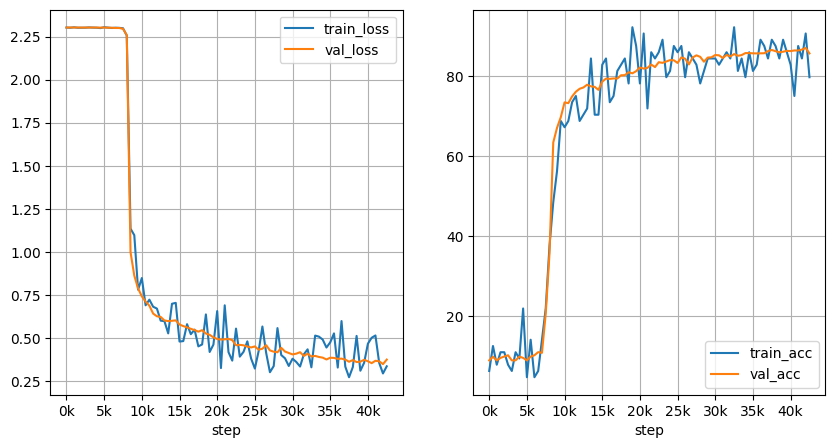

In [87]:
# 绘制学习损失曲线，sample_step是每500步绘制一次
plot_learning_curves(history, sample_step=500)  #横坐标是 steps，纵坐标是 loss，accuracy

In [88]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, val_loader, device, loss_fn)
test_accuracy

(86.72, 0.35295231926441195)